In [18]:
import numpy as np
np.random.seed(0)
from sklearn.model_selection import KFold

num_folds=3
k = KFold(n_splits=num_folds)
list(k.split(range(0, 100)))[1]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]))

In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor, start=160, num_days=112):
    t_subset = tensor[:, :, start:start+num_days, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, num_days*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    print(len(all_indices))
    t_subset = t_subset[all_indices, :, :, :].reshape(len(all_indices), 7, num_days, 24)
    
    # Create artificial aggregate
    t_subset[:, 0, :,:] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :,:] = t_subset[:, 0, :,:] + t_subset[:, i, :,:]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

52


(52, 7, 112, 24)

In [399]:
daily_trend = t_all.mean(axis=2)
daily_trend.shape

(52, 7, 24)

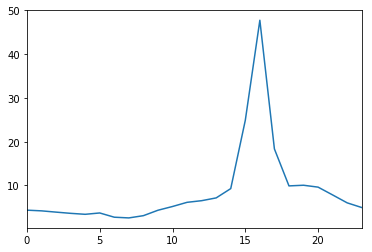

In [400]:
pd.Series(daily_trend[1,6, :]).plot()

In [401]:
train_data = daily_trend[:30,:,:]
test_data = daily_trend[30:,:,:]

### Zero baseline

#### Always predict trends for each appliance as 0


In [402]:
zero_baseline_pred = np.zeros_like(test_data[:,1:,:])

In [403]:
from sklearn.metrics import mean_absolute_error

In [404]:
mae_zero = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    mae_zero[appliance] = mean_absolute_error(test_data[:,appliance_num+1 , :], zero_baseline_pred[:,appliance_num,:])

In [405]:
zero_res = pd.Series(mae_zero)

### Mean baseline

#### Predict the test as the mean of the train set

In [406]:
mean_baseline_pred = np.zeros_like(zero_baseline_pred)
mean_baseline_pred[:] = np.mean(train_data[:,1:,:], axis=0)

In [407]:
mean_baseline_pred.shape

(22, 6, 24)

In [408]:
mae_mean = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    mae_mean[appliance] = mean_absolute_error(test_data[:,appliance_num+1 , :], mean_baseline_pred[:,appliance_num,:])

In [409]:
mean_res = pd.Series(mae_mean)

### KNN on only aggregate features

In [410]:
from sklearn.neighbors import KNeighborsRegressor
pred_knn = {}


for appliance_num in range(6):
    pred_knn[appliance_num]={}
    # Learn for each appliance separately
    train_x = train_data[:, 0, :]
    train_y = train_data[:, appliance_num+1, :]
    for num_neighbours in range(1, 10):
        knn = KNeighborsRegressor(num_neighbours)
        knn.fit(train_x, train_y)
        pred_knn[appliance_num][num_neighbours]=knn.predict(test_data[:,0,:])

In [411]:
mae_knn = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    mae_knn[appliance] = {}
    for num_neighbours in range(1, 10):
       
        mae_knn[appliance][num_neighbours] = mean_absolute_error(test_data[:,appliance_num+1 , :],pred_knn[appliance_num][num_neighbours])

In [412]:
knn_res = pd.DataFrame(mae_knn).min()

In [413]:
from tensorly.decomposition import robust_pca

In [414]:
t_data = daily_trend.copy()
t_data[30:, 1:, :] = np.NaN
low_rank_part, sparse_part = robust_pca(daily_trend, mask=~np.isnan(t_data))

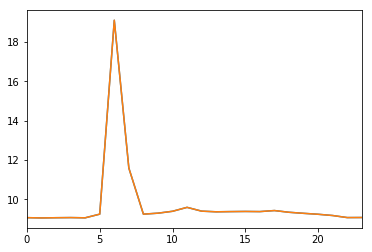

In [415]:
pd.Series(low_rank_part[0, 6, :]).plot()
pd.Series(daily_trend[0, 6, :]).plot()

In [416]:
from tensor_custom_core import stf_3dim, stf_4dim_time, ttf_3dim

In [417]:
pred_stf ={}
for r in range(1, 10):
    H, A, T = stf_3dim(t_data,r=r, num_iter=300)
    print(r)
    pred_stf[r] = np.einsum('Hr, Ar, Tr -> HAT', H, A, T)[30:, 1:, :]

748.985956228 0
183.86764206 50
182.659333663 100
182.639860331 150
182.639474007 200
182.639465931 250
1
747.270319504 0
176.761477579 50
118.42793254 100
117.312421066 150
117.283346445 200
117.279050193 250
2
745.574046267 0
148.039187511 50
103.105081708 100
97.9021139476 150
97.3991786237 200
97.288978086 250
3
743.81472284 0
134.802589031 50
90.2807925767 100
86.9845750076 150
85.6593847643 200
85.2013091163 250
4
742.857914897 0
111.169024538 50
88.321845036 100
82.6895365108 150
79.0772035332 200
77.4583123916 250
5
741.442897321 0
117.0961147 50
88.8196675217 100
77.1923992061 150
71.8278872442 200
68.0964627739 250
6
737.923986052 0
126.167064194 50
82.3480773853 100
71.8085862814 150
64.8357184577 200
61.9264144216 250
7
737.979004875 0
109.969612142 50
80.8437756988 100
67.452332255 150
62.1369933406 200
59.6791183699 250
8
734.711830687 0
112.483500393 50
80.5519501483 100
63.6967092919 150
56.8326907015 200
53.2851838858 250
9


In [418]:
mae_stf = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    mae_stf[appliance] = {}
    for r in range(1, 10):
       
        mae_stf[appliance][r] = mean_absolute_error(test_data[:,appliance_num+1 , :],pred_stf[r][:,appliance_num, :])

In [419]:
stf_results = pd.DataFrame(mae_stf).min()

In [420]:
pred_ttf ={}
for h in range(1, 9):
    pred_ttf[h] = {}
    for t in range(1, 10):
        H, A, T = ttf_3dim(t_data,h=h,t=t, num_iter=200)
        print(h, t)
        pred_ttf[h][t] = np.einsum('Hh, hAt, tT ->HAT', H, A, T)[30:, 1:, :]

748.985956228 0
183.86764206 50
182.659333663 100
182.639860331 150
1 1
747.528857001 0
182.607574628 50
182.063725349 100
181.776790156 150
1 2
745.759531525 0
182.537301702 50
181.983890008 100
181.661052093 150
1 3
744.286701568 0
182.639154576 50
182.430141623 100
181.888173711 150
1 4
742.90402306 0
182.560682699 50
182.10277439 100
181.676959426 150
1 5
741.195512051 0
182.580420908 50
182.216618628 100
181.688446438 150
1 6
739.54171975 0
182.501615385 50
182.051887276 100
181.686546725 150
1 7
738.044669579 0
182.470344562 50
181.907649868 100
181.564769341 150
1 8
736.538378962 0
182.363559402 50
181.765565281 100
181.535824955 150
1 9
747.186609647 0
182.761900702 50
182.599341997 100
182.471208737 150
2 1
743.58117233 0
182.61286034 50
182.368739767 100
181.771518871 150
2 2
741.011273744 0
182.610834474 50
182.330769239 100
181.790589147 150
2 3
737.662319173 0
182.638976302 50
182.505669072 100
182.069410666 150
2 4
733.662187202 0
182.544606172 50
182.090603785 100
181.57

In [426]:
mae_ttf = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    mae_ttf[appliance] = {}
    for h in range(1, 9):
        mae_ttf[appliance][h] = {}
    
        for t in range(1, 10):
            mae_ttf[appliance][h][t] = mean_absolute_error(test_data[:,appliance_num+1 , :],pred_ttf[h][t][:, appliance_num,:])

In [427]:
ttf_results = pd.Panel(mae_ttf).min().min()

In [100]:
H, A, T = ttf_3dim(t_data,h=1,t=6, num_iter=200)

741.195512051 0
182.580420908 50
182.216618628 100
181.688446438 150


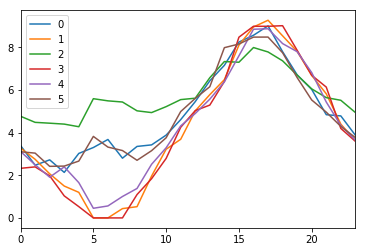

In [101]:
pd.DataFrame(T).T.plot()

In [105]:
H, A, T = stf_3dim(t_data,r=6, num_iter=200)

741.442897321 0
117.0961147 50
88.8196675217 100
77.1923992061 150


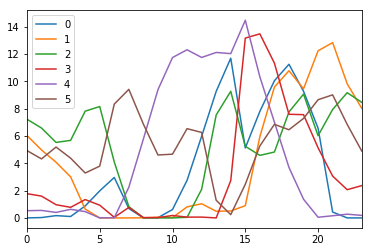

In [106]:
pd.DataFrame(T).plot()

In [381]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, rowLabels=data.index, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


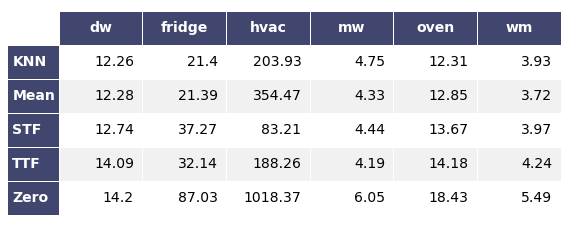

In [99]:
render_mpl_table(main_results.T.round(2), col_width=1.5)
plt.savefig("/Users/nipun/Desktop/res.png")

In [81]:
main_results.T

,dw,fridge,hvac,mw,oven,wm
KNN,12.255020,21.401373,203.931686,4.748065,12.309966,3.934995
Mean,12.276006,21.391676,354.473620,4.325235,12.845249,3.721154
STF,12.741937,37.273678,83.214018,4.444634,13.665692,3.972031
TTF,14.087367,32.135128,188.260544,4.186200,14.176298,4.236309
Zero,14.201703,87.032838,1018.370834,6.054502,18.429772,5.492065


In [23]:
train_data.shape

(30, 7, 24)

In [92]:
from sklearn.decomposition import PCA
pc = {}
for n_components in [1,]:
    pc[n_components] = []
    for a in range(1,7):
       
        pca = PCA(n_components=n_components)
        pca.fit(train_data[:, a, :])
        pc[n_components].append(pca.components_)

In [94]:
T = np.array(pc[n_components]).reshape(6*n_components, -1)

In [95]:
E = test_data[:, 0, :]
E.shape

(22, 24)

In [96]:
T.shape

(6, 24)

In [98]:
H = np.linalg.lstsq(T.transpose(), E.transpose())[0].T

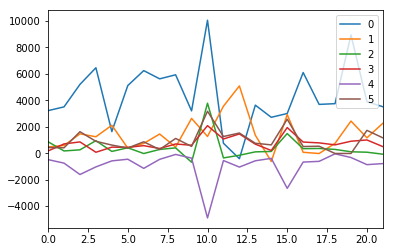

In [105]:
pd.DataFrame(H).plot()

In [108]:
T.shape

(6, 24)

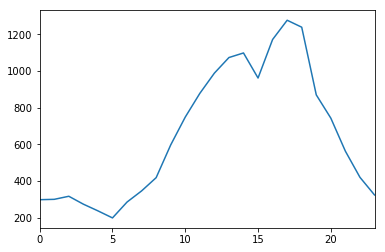

In [126]:
pd.Series(H[13, 0]*T[0, :]).plot()

In [391]:
from sklearn.decomposition import NMF

mf = {}
preds = {}
err_pca_mf = {}
for n_components in range(1, 7):
    preds[n_components] = {}
    mf[n_components] = []
    err_pca_mf[n_components] = {}
    for a in range(1,7):
       
        model = NMF(n_components=n_components, init='random', random_state=0)
        W = model.fit_transform(train_data[:, a, :])
        H = model.components_


        mf[n_components].append(H)
    T = np.array(mf[n_components]).reshape(6*n_components, -1)
    H = nnls_autograd(T, E, case=2, lr=5, num_iter=1000)
    for appliance_num in range(6):
        preds[n_components][APPLIANCES_ORDER[1:][appliance_num]] = np.dot(H[:,appliance_num*n_components:(appliance_num+1)*n_components ], T[appliance_num*n_components:(appliance_num+1)*n_components ,:])
        err_pca_mf[n_components][APPLIANCES_ORDER[1:][appliance_num]] = mean_absolute_error(test_data[:, appliance_num+1, :], preds[n_components][APPLIANCES_ORDER[1:][appliance_num]])

948.608630612 0
276.73486351 10
243.930395146 20
233.245736782 30
227.12407583 40
223.188579309 50
220.510405312 60
218.440513113 70
217.02263453 80
216.079194298 90
215.452056214 100
215.081861675 110
214.62674463 120
214.286548122 130
213.99063346 140
213.720413138 150
213.473923701 160
213.243882668 170
213.027446583 180
212.822519876 190
212.633791896 200
212.489257989 210
212.354316646 220
212.227393703 230
212.107376593 240
211.993397631 250
211.884775533 260
211.780975677 270
211.681582489 280
211.586273292 290
211.494771064 300
211.406747171 310
211.32170881 320
211.23906739 330
211.158486849 340
211.080063496 350
211.004032061 360
210.930466686 370
210.859351725 380
210.791321124 390
210.725749371 400
210.662421032 410
210.601159998 420
210.541820187 430
210.484278196 440
210.428427928 450
210.374176794 460
210.321442997 470
210.270153541 480
210.220243885 490
210.171658846 500
210.124341518 510
210.078240542 520
210.048040218 530
210.023585554 540
210.00132738 550
209.9809956

87.5743260668 620
87.5000152098 630
87.4271264781 640
87.3557696031 650
87.2867383768 660
87.2241376485 670
87.2189222949 680
87.438637915 690
87.1462000812 700
86.9766762936 710
86.9128088276 720
86.8584956485 730
86.8054990416 740
86.7536895728 750
86.7035079504 760
86.663187603 770
87.0725100876 780
86.8650294571 790
86.5122357009 800
86.4583783562 810
86.4111793059 820
86.3646124301 830
86.3185788211 840
86.2787924211 850
86.2465595539 860
86.2149571284 870
86.1838729442 880
86.153249894 890
86.1230469212 900
86.0932372614 910
86.0638015352 920
86.0352024156 930
86.0089058338 940
85.9836502694 950
85.9590930895 960
85.9351072255 970
85.9116245856 980
85.8885994193 990
773.774229015 0
195.145780893 10
143.958309973 20
129.685388556 30
116.760374946 40
106.592726664 50
101.694160403 60
96.7360838695 70
94.7981722771 80
92.7457117543 90
90.5586503295 100
91.1486305145 110
87.9248575513 120
87.2588820086 130
86.0404190069 140
84.0203895283 150
83.1893318808 160
82.4318793772 170
81.777

In [424]:
mf_pca_results = pd.DataFrame(err_pca_mf).round().min(axis=1)
mf_pca_results

dw         33.0
fridge    106.0
hvac      195.0
mw         39.0
oven       29.0
wm         13.0
dtype: float64

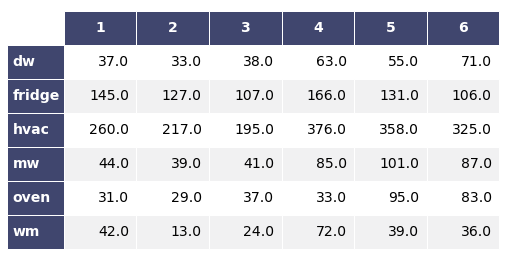

In [393]:
render_mpl_table(pd.DataFrame(err_pca_mf).round(), col_width=1.3)
plt.savefig("/Users/nipun/Desktop/mf-pca.png")

In [428]:
main_results = pd.DataFrame({"STF":stf_results, "TTF":ttf_results,
                             "Zero":zero_res, "Mean":mean_res,
                            "KNN":knn_res, "PCA":mf_pca_results})

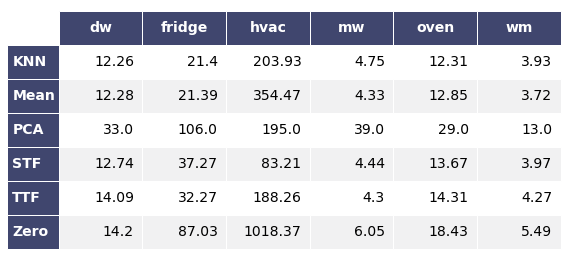

In [430]:
render_mpl_table(main_results.T.round(2), col_width=1.5)
plt.savefig("/Users/nipun/Desktop/res.png")

In [384]:
def nnls_autograd(A, B, case=1, num_iter=300, eps=1e-8, lr=4):
    """
    Case 1: Ax = B
    Case 2: xA = B
    """
    
    import autograd.numpy as np
    np.random.seed(0)
    from autograd import grad
    
    if case==1:
        def cost(A, B, x):

            error = A@x - B
            return np.sqrt((error ** 2).mean())
    else:
        def cost(A, B, x):

            error = x@A - B
            return np.sqrt((error ** 2).mean())
        
    
    mg = grad(cost, argnum=2)
    
    M, N = B.shape
    
    if case==1:
        r = A.shape[1]
        x = np.abs(np.random.randn(r, N))
    else:
        r = A.shape[0]
        x = np.abs(np.random.randn(M, r))
  
    sum_x =  np.zeros_like(x)
    
    for i in range(num_iter):
        del_x = mg(A, B, x)
        sum_x += eps + np.square(del_x)
        lr_x = np.divide(lr, np.sqrt(sum_x))
        x -= lr_x * del_x
        
        x[x<0]=0.
        
        if i % 10 == 0:
            print(cost(A, B, x), i)
            sys.stdout.flush()

    return x    

In [359]:
H.shape, T.shape

((22, 30), (30, 24))

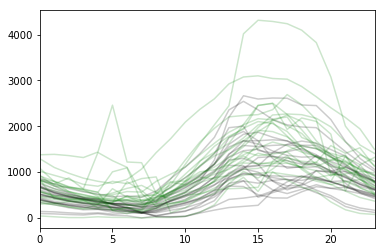

In [361]:
appliance_num=0
ax = pd.DataFrame(H[:, n_components*appliance_num:n_components*(appliance_num+1)]@T[n_components*appliance_num:n_components*(appliance_num+1), :]).T.plot(color='k',alpha=0.2, legend=False)

pd.DataFrame(test_data[:, 1, :]).T.plot(color='g',alpha=0.2, legend=False,ax=ax)

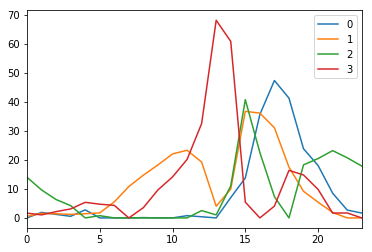

In [362]:
pd.DataFrame(T[0:4]).T.plot()

In [363]:
T.shape, H.shape

((30, 24), (22, 30))

In [364]:
preds = {}
for appliance_num in range(6):
    preds[appliance_num] = np.dot(H[:,appliance_num*n_components:(appliance_num+1)*n_components ], T[appliance_num*n_components:(appliance_num+1)*n_components ,:])

324.962573579 0
128.415405616 1
73.0839735032 2
53.5526775808 3
33.2588812001 4
78.0731149302 5


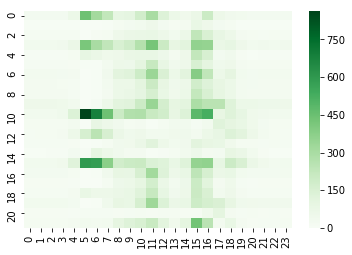

In [372]:
import seaborn as sns
sns.heatmap(preds[2],cmap='Greens')

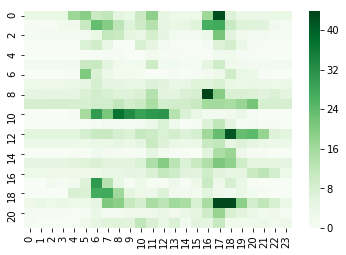

In [373]:
sns.heatmap(test_data[:, 3, :],cmap='Greens')

In [316]:
(preds[1] - test_data[:, 2, :]).mean()

403.37396872065591

In [317]:
test_data.shape

(22, 7, 24)

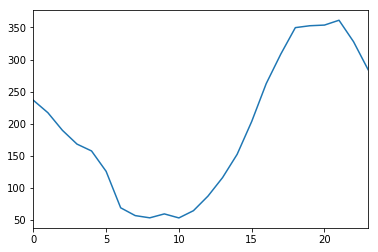

In [320]:
pd.Series(preds[1][0]).plot()

In [160]:
def cost(E, H, T):
    return np.abs(E-H*T)

In [161]:
from autograd import grad

In [162]:
grad_f = grad(cost, argnum=[0,1,2])

In [ ]:
H = np.random.randn()

In [84]:
import subprocess
filename = 'out.tex'
pdffile = 'out.pdf'
outname = 'out.png'

template = r'''\documentclass[preview]{{standalone}}
\usepackage{{booktabs}}
\begin{{document}}
{}
\end{{document}}
'''

with open(filename, 'wb') as f:
    f.write(bytes(template.format(main_results.to_latex()),'UTF-8'))

subprocess.call(['pdflatex', filename])
subprocess.call(['convert', '-density', '300', pdffile, '-quality', '90', outname])

FileNotFoundError: [Errno 2] No such file or directory: 'convert': 'convert'

In [443]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2)
S_ = ica.fit_transform(train_data[:, 1, :])  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

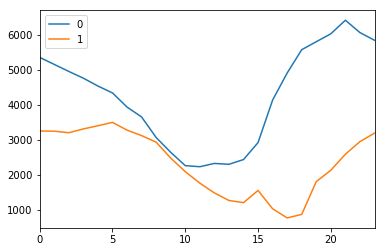

In [447]:
(pd.DataFrame(A_)+4000).plot()